# Model for the electro-mechanical behavior of elastic organic transistors

Reynolds, V.G., Oh, S., Xie, R. and Chabinyc, M.L., 2020. Model for the electro-mechanical behavior of elastic organic transistors. Journal of Materials Chemistry C, 8(27), pp.9276-9285.

https://doi.org/10.1039/D0TC01181A

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab
from pylab import cm

mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [2]:
# Define a class that describes our elastic transistors

class transistor():
    
    def __init__(self, flavor, Ttype, W, L, d, C_G, mu, V_T, deformAxis):
        
        # Flavor of transistor: TFT, EDLT, or OECT
        self.flavor = flavor
        
        # Transistor type (p-type or n-type)
        self.Ttype = Ttype
        
        # Channel width and length
        self.W = W
        self.L = L
        
        # Thickness of the semiconducting layer; only needs to be defined for OECTs
        self.d = d
        
        # Gate capacitance, F/m^2 for TFT and EFLT; for OECT this is volumetric capacitance, F/m^3
        self.C_G = C_G
        
        # Mobility, m^2/Vs
        self.mu = mu
        
        # Threshold voltage (V)
        self.V_T = V_T
        
        if self.Ttype == 'n':
            self.V_G = V_in
            self.V_SD = V_out
            self.I_SD_maxidx = len(self.V_G)-1
        elif self.Ttype == 'p':
            self.V_G = V_in-V_DD
            self.V_SD = V_out-V_DD
            self.I_SD_maxidx = 0
        
        # Deformation axis options: 
        # (1) uniaxial along channel length 'uniaxial-L'
        # (2) uniaxial along channel width 'uniaxial-W'
        # (3) biaxial 'biaxial-WL'
        self.deformAxis = deformAxis
        
        if self.deformAxis == 'uniaxial-L':
            
            self.erL = er
            self.erW = 1/(self.erL**(1/2))
            self.ert = 1/(self.erL**(1/2))
        
        elif self.deformAxis == 'uniaxial-W':
            
            self.erW = er
            self.erL = 1/(self.erW**(1/2))
            self.ert = 1/(self.erW**(1/2))
            
        elif self.deformAxis == 'biaxial-WL':
            
            self.erL = er
            self.erW = er
            self.ert = np.zeros((len(self.erW), len(self.erL)))
            for i in range(len(self.erW)):
                for j in range(len(self.erL)):
                    self.ert[i,j] = 1/(self.erL[j]*self.erW[i])
            
        self.V_SD_satidx = np.abs(np.abs(self.V_SD)-np.abs(V_DD)).argmin()
        
        # Define the constant beta, the strain-dependent V_T, and the strain-dependent C_G based on transistor type
        
        if self.flavor == 'TFT':
            self.beta = (self.W/self.L)*self.mu*self.C_G
            self.V_T_er = self.V_T*self.ert
            self.C_G_er = self.C_G*(self.ert**(-1))
            if self.deformAxis == 'uniaxial-L' or self.deformAxis == 'uniaxial-W':
                self.geo_er = (self.W*self.erW)/(self.L*self.erL)
            elif self.deformAxis == 'biaxial-WL':
                self.geo_er = np.zeros((len(self.erW), len(self.erL)))
                for i in range(len(self.erW)):
                    for j in range(len(self.erL)):
                        self.geo_er[i,j] = (self.W*self.erW[i])/(self.L*self.erL[j])
                
        elif self.flavor == 'EDLT':
            self.beta = (self.W/self.L)*self.mu*self.C_G
            self.V_T_er = self.V_T*np.ones(np.shape(self.ert))
            self.C_G_er = self.C_G*np.ones(np.shape(self.ert))
            if self.deformAxis == 'uniaxial-L' or self.deformAxis == 'uniaxial-W':
                self.geo_er = (self.W*self.erW)/(self.L*self.erL)
            elif self.deformAxis == 'biaxial-WL':
                self.geo_er = np.zeros((len(self.erW), len(self.erL)))
                for i in range(len(self.erW)):
                    for j in range(len(self.erL)):
                        self.geo_er[i,j] = (self.W*self.erW[i])/(self.L*self.erL[j])
                
        elif self.flavor == 'OECT':
            self.beta = (self.W/self.L)*self.d*self.mu*self.C_G
            self.V_T_er = self.V_T*np.ones(np.shape(self.ert))
            self.C_G_er = self.C_G*np.ones(np.shape(self.ert))
            if self.deformAxis == 'uniaxial-L' or self.deformAxis == 'uniaxial-W':
                self.geo_er = ((self.W*self.erW)/(self.L*self.erL))*(self.d*self.ert)
            elif self.deformAxis == 'biaxial-WL':
                self.geo_er = np.zeros((len(self.erW), len(self.erL)))
                for i in range(len(self.erW)):
                    for j in range(len(self.erL)):
                        self.geo_er[i,j] = ((self.W*self.erW[i])/(self.L*self.erL[j]))*(self.d*self.ert[i,j])
                
        else:
            print('Not a valid flavor of transistor.')
            
        # Calculate I_SD
            
        if self.deformAxis == 'uniaxial-L' or self.deformAxis ==  'uniaxial-W':

            self.I_SD = np.zeros((np.size(self.V_SD), np.size(self.V_G), np.size(self.erL)))

            for i in range(np.size(self.erL)):
                for j in range(np.size(self.V_G)):
                    for k in range(np.size(self.V_SD)):
                        if abs(self.V_G[j])<abs(self.V_T_er[i]):
                            self.I_SD[k,j,i]=0
                        elif abs(self.V_SD[k])<abs(self.V_G[j]-self.V_T_er[i]): # linear regime
                            self.I_SD[k,j,i]=self.geo_er[i]*self.C_G_er[i]*self.mu*(((self.V_G[j]-self.V_T_er[i])*self.V_SD[k])-((self.V_SD[k]**2)/2))
                        elif abs(self.V_SD[k])>=abs(self.V_G[j]-self.V_T_er[i]): # saturation regime
                            self.I_SD[k,j,i]=self.geo_er[i]*self.C_G_er[i]*self.mu*(((self.V_G[j]-self.V_T_er[i])**2)/2)

        elif self.deformAxis == 'biaxial-WL':

            self.I_SD = np.zeros((np.size(self.V_SD), np.size(self.V_G), np.size(self.erW), np.size(self.erL)))

            for h in range(np.size(self.erL)):
                for i in range(np.size(self.erW)):
                    for j in range(np.size(self.V_G)):
                        for k in range(np.size(self.V_SD)):
                            if abs(self.V_G[j])<abs(self.V_T_er[i,h]):
                                self.I_SD[k,j,i,h]=0
                            elif abs(self.V_SD[k])<abs(self.V_G[j]-self.V_T_er[i,h]): # linear regime
                                self.I_SD[k,j,i,h]=self.geo_er[i,h]*self.C_G_er[i,h]*self.mu*(((self.V_G[j]-self.V_T_er[i,h])*self.V_SD[k])-((self.V_SD[k]**2)/2))
                            elif abs(self.V_SD[k])>=abs(self.V_G[j]-self.V_T_er[i,h]): # saturation regime
                                self.I_SD[k,j,i,h]=self.geo_er[i,h]*self.C_G_er[i,h]*self.mu*(((self.V_G[j]-self.V_T_er[i,h])**2)/2)
        
        # Calculate the relative source-drain current (I_SD/I_SD(er=1)) in the saturation regime
        # The value of V_G that gives the highest magnitude I_SD is used

        if self.deformAxis == 'uniaxial-L' or self.deformAxis ==  'uniaxial-W':

            self.I_SDrel = np.zeros(np.size(self.erL))
            self.I_SD_undeformed = self.I_SD[self.V_SD_satidx, self.I_SD_maxidx, er_1_idx]

            for i in range(np.size(self.erL)):
                self.I_SDrel[i] = self.I_SD[self.V_SD_satidx, self.I_SD_maxidx,i]/self.I_SD_undeformed

        elif self.deformAxis == 'biaxial-WL':

            self.I_SDrel = np.zeros((np.size(self.erW), np.size(self.erL)))
            self.I_SD_undeformed = self.I_SD[self.V_SD_satidx, self.I_SD_maxidx, er_1_idx, er_1_idx]

            for i in range(np.size(self.erL)):
                for j in range(np.size(self.erW)):
                    self.I_SDrel[j,i] = self.I_SD[self.V_SD_satidx, self.I_SD_maxidx, j, i]/self.I_SD_undeformed


In [3]:
class inverter():
    
    def __init__(self, ntype, ptype):
        
        self.ntype = ntype
        self.ptype = ptype

        # Build the voltage transfer curve (V_TC) by finding where the n- and p-type load curves cross
        # The accuracy of this calculation depends on your voltage scan resolution, V_resolution

        if (self.ntype.deformAxis == 'uniaxial-L' or self.ntype.deformAxis ==  'uniaxial-W') and (self.ptype.deformAxis == 'uniaxial-L' or self.ptype.deformAxis ==  'uniaxial-W'):
            self.V_out_cross = np.zeros((np.size(V_in,0),np.size(er,0)))
            for i in range(np.size(er)):
                for j in range (np.size(V_in)):
                    for k in range (np.size(V_out)):
                        if self.ntype.I_SD[k,j,i]>=self.ptype.I_SD[k,j,i]:
                            self.V_out_cross[j,i] = V_out[k]
                            break

        elif (self.ntype.deformAxis == 'biaxial-WL') and (self.ptype.deformAxis == 'biaxial-WL'):
            self.V_out_cross = np.zeros((np.size(V_in),np.size(er),np.size(er)))
            for h in range(np.size(er)):
                for i in range(np.size(er)):
                    for j in range (np.size(V_in)):
                        for k in range (np.size(V_out,0)):
                            if self.ntype.I_SD[k,j,i,h]>=self.ptype.I_SD[k,j,i,h]:
                                self.V_out_cross[j,i,h] = V_out[k]
                                break
                                
        else:
            print('This deformation scenario is unsupported.')

In [4]:
# Plot relative source-drain current in the saturation regime vs. extension ratio

def plot_I_SDrel(transistor):
    
    if transistor.deformAxis == 'uniaxial-L' or transistor.deformAxis ==  'uniaxial-W':

        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
        ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
        ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

        ax.set_xlabel('Extension Ratio, $\lambda$', labelpad=10)
        ax.set_ylabel('Relative Current, $I_\mathrm{SD}/I_\mathrm{SD}^\mathrm{initial}$', labelpad=10)

        ax.plot(er, transistor.I_SDrel, linewidth=2)

        plt.show()
        
    elif transistor.deformAxis == 'biaxial-WL':
        
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_axes([0, 0, 1, 1])
        
        ax.set_xlabel('$\lambda_L$', labelpad=10)
        ax.set_ylabel('$\lambda_W$', labelpad=10)
        
        im = ax.imshow(transistor.I_SDrel, interpolation='none', cmap=pylab.get_cmap('viridis'),
               origin='lower', extent=[np.min(er), np.max(er), np.min(er), np.max(er)])
        
        fig.colorbar(im, ax=ax)
        
        plt.show()

In [5]:
# Plot a series of load curves vs. deformation

def plot_LCvsDeformation(transistor):
    
    if transistor.deformAxis == 'uniaxial-L' or transistor.deformAxis ==  'uniaxial-W':

        er_plot = np.array([0.5, 0.75, 1, 1.5, 2])

        idx_er = np.zeros((np.size(er_plot)))

        for i in range((np.size(er_plot))):
            idx_er[i] = (np.abs(er - er_plot[i])).argmin()

        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
        ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
        ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

        ax.set_xlim(0, np.max(V_out))

        ax.set_xlabel('$V_\mathrm{out}$ (V)', labelpad=10)
        ax.set_ylabel('$I_\mathrm{SD}$ (A)', labelpad=10)

        cm = pylab.get_cmap('viridis')

        for i in range((np.size(er_plot,0))):
            ax.plot(V_out, transistor.I_SD[:,transistor.I_SD_maxidx,int(idx_er[i])], 
                    linewidth=2, 
                    color=cm(1.*i/np.size(er_plot)), 
                    label=(str(er_plot[i])))

        plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

        plt.show()

        #plt.savefig('Final_Plot.png', dpi=300, transparent=False, bbox_inches='tight')
        
    else:
        
        print('Currently unsupported.')

In [6]:
# Plot a series of load curves

def plot_LC(inverter):

    if (inverter.ntype.deformAxis == 'uniaxial-L' or inverter.ntype.deformAxis ==  'uniaxial-W') and (inverter.ptype.deformAxis == 'uniaxial-L' or inverter.ptype.deformAxis ==  'uniaxial-W'):

        # Set deformation
        er_LC_plot = 1

        # Set list of V_in's
        V_in_LC_plot = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40])

        idx_er = (np.abs(er - er_LC_plot)).argmin()
        idx_n = np.zeros((np.size(V_in_LC_plot)))
        idx_p = np.zeros((np.size(V_in_LC_plot)))

        for i in range((np.size(V_in_LC_plot))):
            idx_n[i] = (np.abs(inverter.ntype.V_G - V_in_LC_plot[i])).argmin()

        for i in range((np.size(V_in_LC_plot))):
            idx_p[i] = (np.abs(inverter.ptype.V_G - (V_in_LC_plot[i]-V_DD))).argmin()

        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
        ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
        ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

        ax.set_xlim(0, V_DD)
        ax.set_ylim(0, 1.05*np.max(inverter.ntype.I_SD[:,:,idx_er]))

        ax.set_xlabel('$V_\mathrm{SD}$ (V)', labelpad=10)
        ax.set_ylabel('$I_\mathrm{SD}$ (A)', labelpad=10)

        cm = pylab.get_cmap('viridis')

        for i in range((np.size(V_in_LC_plot))):
            ax.plot(V_out, inverter.ntype.I_SD[:,int(idx_n[i]),idx_er], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), label=(str(V_in_LC_plot[i])+' V'))
            ax.plot(V_out, inverter.ptype.I_SD[:,int(idx_p[i]),idx_er], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), linestyle='--')

        plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

        plt.show()

        #plt.savefig('Final_Plot.png', dpi=300, transparent=False, bbox_inches='tight')
        
    else:
        
        print('Currently unsupported.')

In [7]:
# Plot a series of load curves

def plot_LC_alternative(inverter):

    if (inverter.ntype.deformAxis == 'uniaxial-L' or inverter.ntype.deformAxis ==  'uniaxial-W') and (inverter.ptype.deformAxis == 'uniaxial-L' or inverter.ptype.deformAxis ==  'uniaxial-W'):

        # Set deformation
        er_LC_plot = 1

        # Set list of V_in's
        V_in_LC_plot = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40])

        idx_er = (np.abs(er - er_LC_plot)).argmin()
        idx_n = np.zeros((np.size(V_in_LC_plot)))
        idx_p = np.zeros((np.size(V_in_LC_plot)))

        for i in range((np.size(V_in_LC_plot))):
            idx_n[i] = (np.abs(ntype.V_G - V_in_LC_plot[i])).argmin()

        for i in range((np.size(V_in_LC_plot))):
            idx_p[i] = (np.abs(ptype.V_G - (V_in_LC_plot[i]-V_DD))).argmin()

        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
        ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
        ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

        ax.set_xlabel('$V_\mathrm{SD}$ (V)', labelpad=10)
        ax.set_ylabel('$I_\mathrm{SD}$ (A)', labelpad=10)

        cm = pylab.get_cmap('viridis')

        for i in range((np.size(V_in_LC_plot))):
            ax.plot(ntype.V_SD, ntype.I_SD[:,int(idx_n[i]),idx_er], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), label=(str(V_in_LC_plot[i])+' V'))
            ax.plot(ptype.V_SD, ptype.I_SD[:,int(idx_p[i]),idx_er], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), linestyle='--')

        plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

        plt.show()

        #plt.savefig('Final_Plot.png', dpi=300, transparent=False, bbox_inches='tight')
        
    else:
        
        print('Currently unsupported.')

In [8]:
# Plot the voltage transfer curve of the inverter vs. deformation

def plot_VTC(inverter):
    
    if (inverter.ntype.deformAxis == 'uniaxial-L' or inverter.ntype.deformAxis ==  'uniaxial-W') and (inverter.ptype.deformAxis == 'uniaxial-L' or inverter.ptype.deformAxis ==  'uniaxial-W'):

        er_plot = np.array([0.5, 0.75, 1, 1.5, 2])
        
        # Set list of V_in's
        V_in_LC_plot = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40])

        idx_er = np.zeros((np.size(er_plot)))

        for i in range((np.size(er_plot))):
            idx_er[i] = (np.abs(er - er_plot[i])).argmin()

        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
        ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
        ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

        ax.set_xlim(np.min(V_in), np.max(V_in))
        ax.set_ylim((np.min(inverter.V_out_cross)-0.05*np.max(inverter.V_out_cross)), 1.05*np.max(inverter.V_out_cross))

        ax.set_xlabel('$V_\mathrm{in}$ (V)', labelpad=10)
        ax.set_ylabel('$V_\mathrm{out}$ (V)', labelpad=10)

        cm = pylab.get_cmap('viridis')

        for i in range((np.size(er_plot,0))):
            ax.plot(V_in, inverter.V_out_cross[:,int(idx_er[i])], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), label=(str(er_plot[i])))

        plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

        plt.show()
        
    else:
        
        print('Currently unsupported.')

In [9]:
# Generate flipped and rotated V_TC for creating eye diagram

def plot_VTC_eye(inverter):

    if (inverter.ntype.deformAxis == 'uniaxial-L' or inverter.ntype.deformAxis ==  'uniaxial-W') and (inverter.ptype.deformAxis == 'uniaxial-L' or inverter.ptype.deformAxis ==  'uniaxial-W'):

        eye_x = np.zeros((np.size(inverter.V_out_cross,0),np.size(er,0)))
        eye_y = np.zeros((np.size(inverter.V_out_cross,0),np.size(er,0)))

        for i in range(np.size(er,0)):
            eye_x[:,i] = -inverter.V_out_cross[:,i]+V_DD
            eye_y[:,i] = np.flip(V_in)

        # Plot the voltage transfer curve of the inverter vs. deformation, with transformed data to highlight the eye of operation

        er_plot = np.array([0.5, 0.75, 1, 1.5, 2])
        
        # Set list of V_in's
        V_in_LC_plot = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40])

        idx_er = np.zeros((np.size(er_plot)))

        for i in range((np.size(er_plot))):
            idx_er[i] = (np.abs(er - er_plot[i])).argmin()

        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
        ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
        ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

        ax.set_xlim((np.min(V_in)-0.05*np.max(V_in)), 1.05*np.max(V_in))
        ax.set_ylim((np.min(inverter.V_out_cross)-0.05*np.max(inverter.V_out_cross)), 1.05*np.max(inverter.V_out_cross))

        ax.set_xlabel('$V_\mathrm{in}$ (V)', labelpad=10)
        ax.set_ylabel('$V_\mathrm{out}$ (V)', labelpad=10)

        cm = pylab.get_cmap('viridis')

        for i in range((np.size(er_plot,0))):
            ax.plot(V_in, inverter.V_out_cross[:,int(idx_er[i])], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)), label=(str(er_plot[i])))
            ax.plot(eye_x[:,int(idx_er[i])], eye_y[:,int(idx_er[i])], linewidth=2, color=cm(1.*i/np.size(V_in_LC_plot)),linestyle='--')

        plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

        plt.show()
        
    else:
        
        print('Currently unsupported.')

In [10]:
# Define voltage parameters
V_DD = 1.1 # supply voltage, V
V_resolution = 100 # number of datapoints for the voltage transfer curve
V_in = np.linspace(0,V_DD,V_resolution)
V_out = np.linspace(0,V_DD,V_resolution)

# Set the deformation range (extension ratio, er)
# Note: the deformation range must include the undeformed state (er=1)
#er = np.array([0.5, 0.75, 1, 1.5, 2])
#er = np.concatenate((np.linspace(0.5, 1, 9, endpoint=False), np.linspace(1, 2, 10)))
er = np.linspace(0.5, 2, 25)

er_1_idx = np.where(er==1)

if 1 not in er:
    print('The range of extension ratios to be modeled must include 1 (the undeformed state).')

In [11]:
ntype = transistor(flavor='OECT',
                   Ttype='n', 
                   W=1, 
                   L=1, 
                   d=1E-7, 
                   C_G=40000000, 
                   mu=1E-4, 
                   V_T=0.5,
                   deformAxis='uniaxial-L')

In [12]:
ptype = transistor(flavor='OECT',
                   Ttype='p', 
                   W=1, 
                   L=1, 
                   d=1E-7, 
                   C_G=40000000, 
                   mu=1E-4, 
                   V_T=-0.5,
                   deformAxis='uniaxial-W')

In [13]:
inverter_test = inverter(ntype, ptype)

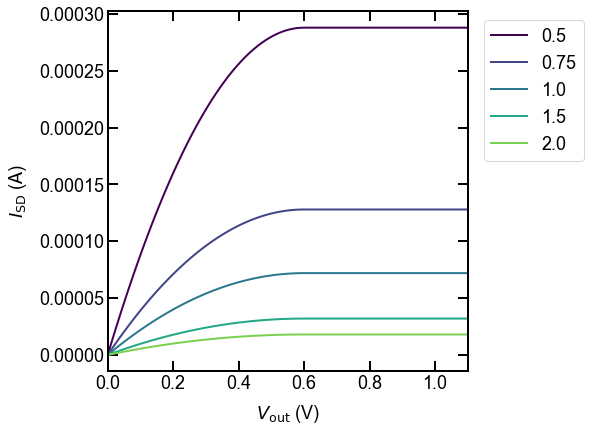

In [14]:
plot_LCvsDeformation(ntype)

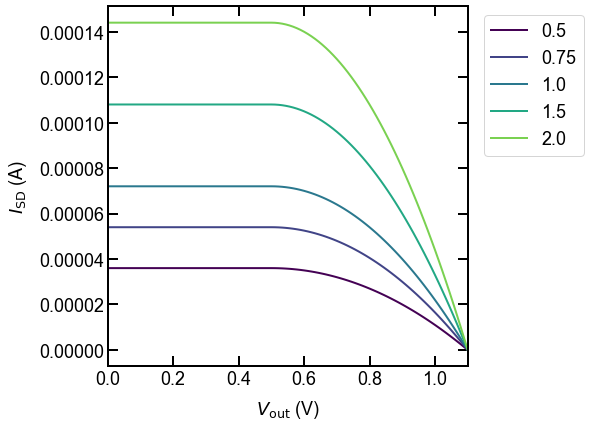

In [15]:
plot_LCvsDeformation(ptype)

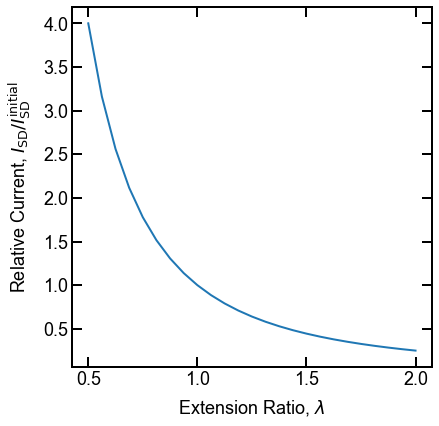

In [16]:
plot_I_SDrel(ntype)

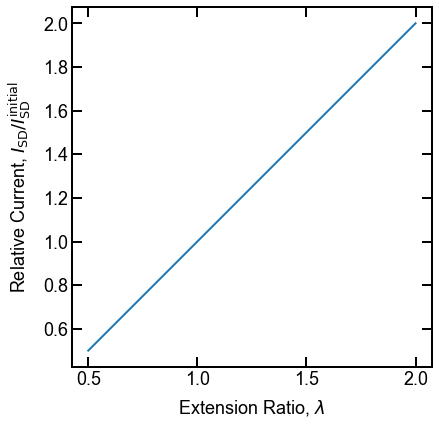

In [17]:
plot_I_SDrel(ptype)

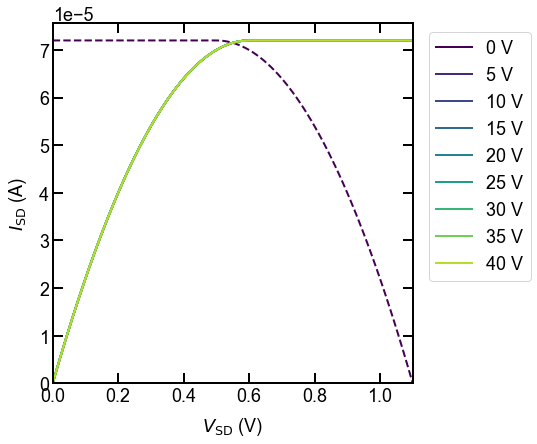

In [18]:
plot_LC(inverter_test)

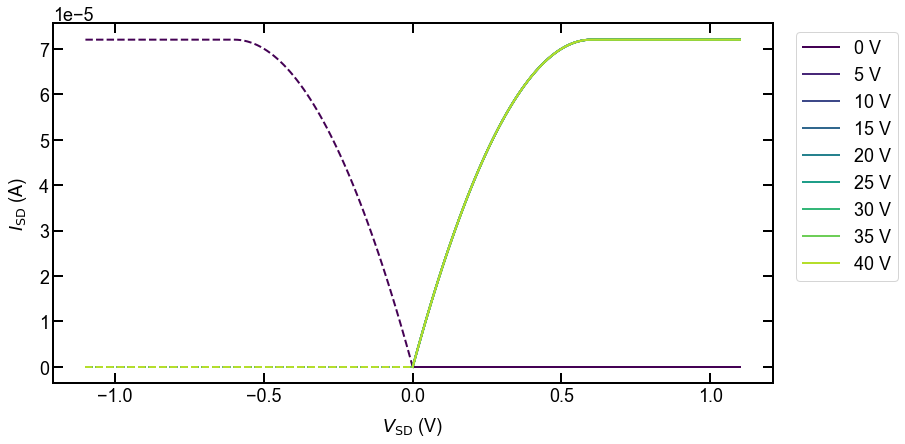

In [19]:
plot_LC_alternative(inverter_test)

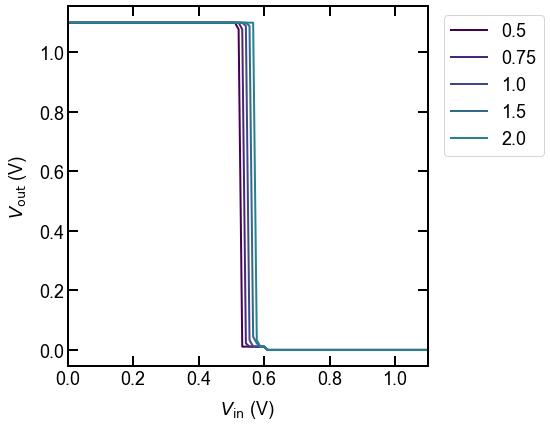

In [20]:
plot_VTC(inverter_test)

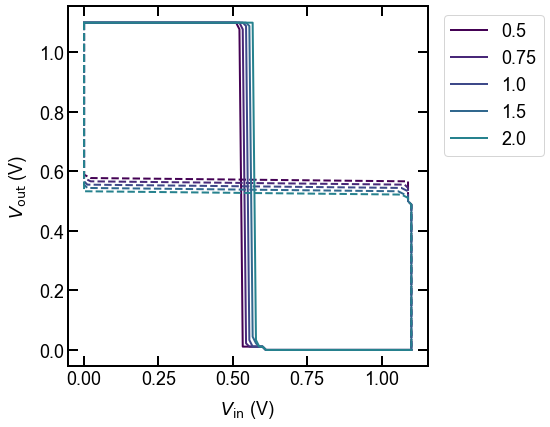

In [21]:
plot_VTC_eye(inverter_test)